In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# Load data
bank_df = pd.read_csv(r"E:\Michaelmas\BU1745-Foundational BA\Group Project\bank-full.csv")

In [3]:
# Check for null values in each column
null_values = bank_df.isnull().sum()
print(null_values)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [4]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
bank_df['y']=bank_df['y'].map({'yes': 1, 'no': 0}).astype(int)

#### Ques 1: Key customer characteristics and campaign factors impacting the likelihood of term deposit subscription

#### Exploratory Data Analysis

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\1770152775.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subscription_counts = bank_df.groupby(['month', 'y']).size().unstack(fill_value=0)


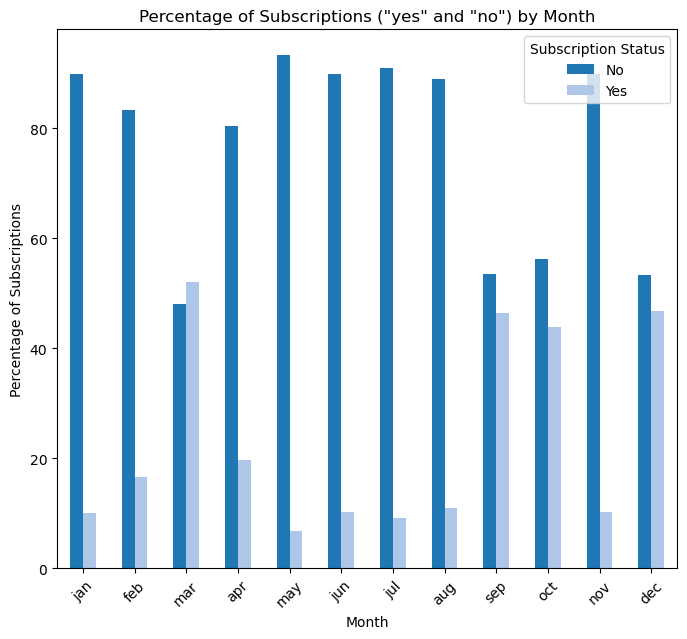

In [7]:
# Percentage of Subscriptions by Month
# Order of months
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

# Convert 'month' column to categorical type
bank_df['month'] = pd.Categorical(bank_df['month'], categories=month_order, ordered=True)

# Percentage of 'yes' and 'no' responses for each month
subscription_counts = bank_df.groupby(['month', 'y']).size().unstack(fill_value=0)
subscription_percentages = subscription_counts.div(subscription_counts.sum(axis=1), axis=0) * 100

# Plot
subscription_percentages.plot(kind='bar', stacked=False, color = ['#1f77b4', '#aec7e8'], figsize=(8, 7))
# Adding labels and title
plt.title('Percentage of Subscriptions ("yes" and "no") by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Subscriptions')
plt.legend(title='Subscription Status', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

In [8]:
# Binning the 'age' column 
bank_df['age_group'] = pd.cut(bank_df['age'], bins=[0, 25, 40, 60, 100], labels=['young', 'middle-aged', 'older', 'senior'])

# Binning the 'balance' column
bank_df['balance_group'] = pd.cut(bank_df['balance'], bins=[0, 1000, 10000, 100000], labels=['low', 'medium', 'high'])

bank_df[['age', 'age_group', 'balance', 'balance_group']].head()

,age,age_group,balance,balance_group
0,58,older,2143,medium
1,44,older,29,low
2,33,middle-aged,2,low
3,47,older,1506,medium
4,33,middle-aged,1,low


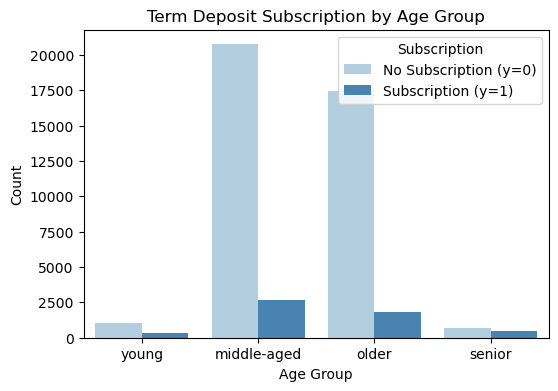

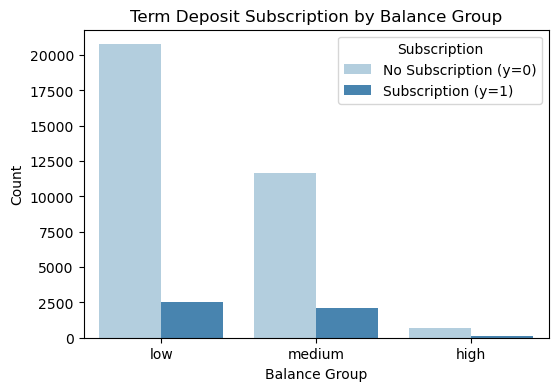

In [9]:
# Visualizing the relationship between 'age_group' and subscription (y)
plt.figure(figsize=(6, 4))
sns.countplot(data=bank_df, x='age_group', hue='y', palette='Blues')
plt.title('Term Deposit Subscription by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Subscription', labels=['No Subscription (y=0)', 'Subscription (y=1)'])
plt.show()

# Visualizing the relationship between 'balance_group' and subscription (y)
plt.figure(figsize=(6, 4))
sns.countplot(data=bank_df, x='balance_group', hue='y', palette='Blues')
plt.title('Term Deposit Subscription by Balance Group')
plt.xlabel('Balance Group')
plt.ylabel('Count')
plt.legend(title='Subscription', labels=['No Subscription (y=0)', 'Subscription (y=1)'])
plt.show()

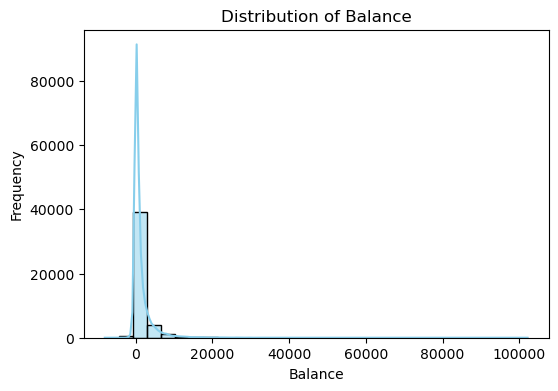

In [10]:
# Distribution of the 'balance' variable - to check if we need transformation while modeling
plt.figure(figsize=(6, 4))
sns.histplot(bank_df['balance'], bins=30, kde=True, color='skyblue')
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.title("Distribution of Balance")
plt.show()

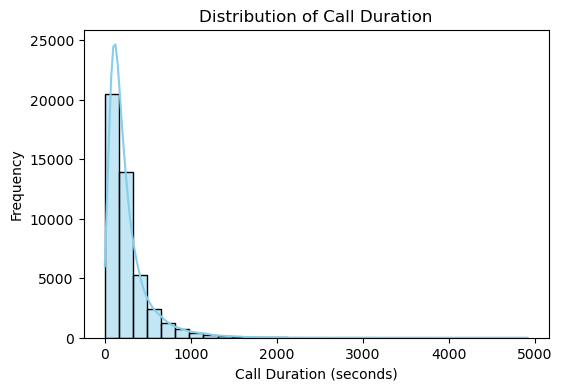

In [11]:
# Distribution of the 'duration' variable - to check if we need transformation while modeling (Data is rightly skewed)
plt.figure(figsize=(6, 4))
sns.histplot(bank_df['duration'], bins=30, kde=True, color='skyblue')
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Call Duration")
plt.show()

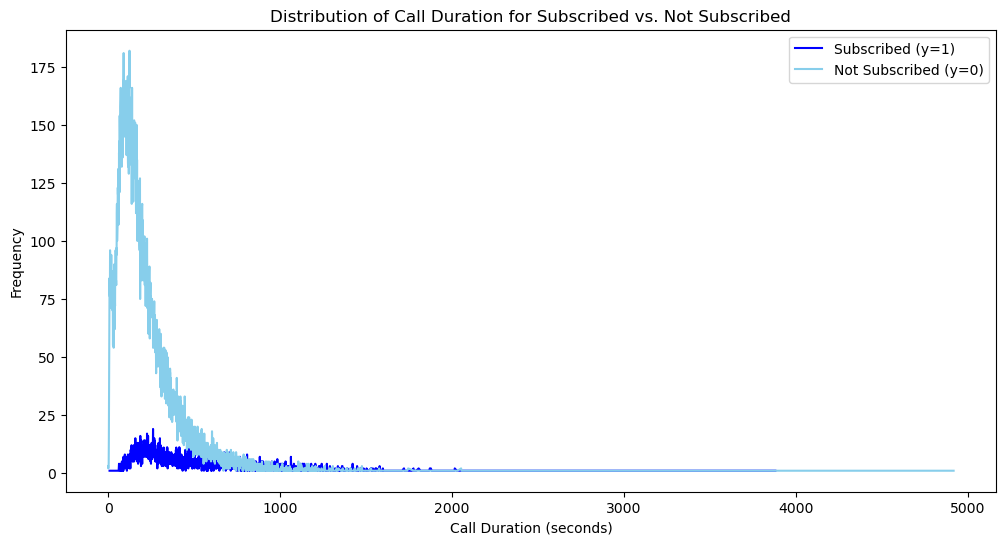

In [12]:
subscribed_durations = bank_df[bank_df['y'] == 1]['duration']
non_subscribed_durations = bank_df[bank_df['y'] == 0]['duration']

# Calculate the count of subscriptions and non-subscriptions for each duration
duration_counts_subscribed = subscribed_durations.value_counts().sort_index()
duration_counts_non_subscribed = non_subscribed_durations.value_counts().sort_index()

# Plotting both to see the distributions side-by-side
plt.figure(figsize=(12, 6))
plt.plot(duration_counts_subscribed.index, duration_counts_subscribed.values, label='Subscribed (y=1)', color='blue')
plt.plot(duration_counts_non_subscribed.index, duration_counts_non_subscribed.values, label='Not Subscribed (y=0)', color='skyblue')
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Call Duration for Subscribed vs. Not Subscribed")
plt.legend()
plt.show()

# Can remove records where duration is more than 2000. Data loss is minimal

In [13]:
bank_df['job'].value_counts().sort_index()
# Unknown jobs accounts for only 0.64% of data

job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

<Figure size 1400x800 with 0 Axes>

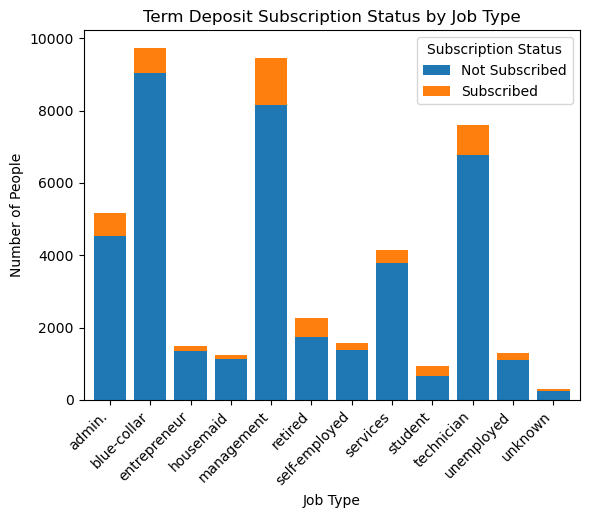

In [14]:
# Term deposit subscription by job type
bank_df['y_subscribed'] = bank_df['y'].map({1: 'Subscribed', 0: 'Not Subscribed'})
job_subscription_counts = bank_df.groupby(['job', 'y_subscribed']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 8))
job_subscription_counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], width=0.8)
plt.xlabel("Job Type")
plt.ylabel("Number of People")
plt.title("Term Deposit Subscription Status by Job Type")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Subscription Status")
plt.show()

In [15]:
# Drop the unnnecessary columns
bank_df = bank_df.drop(['age_group', 'balance_group', 'y_subscribed'], axis=1)

In [16]:
# Occurrences of campaign
campaign_counts = bank_df['campaign'].value_counts().sort_index()

# Rate of term deposit subscriptions
subscription_rate = bank_df['y'].value_counts(normalize=True) * 100

print("Number of campaigns contact counts for each campaign:-")
print(campaign_counts)

Number of campaigns contact counts for each campaign:-
campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
24       20
25       22
26       13
27       10
28       16
29       16
30        8
31       12
32        9
33        6
34        5
35        4
36        4
37        2
38        3
39        1
41        2
43        3
44        1
46        1
50        2
51        1
55        1
58        1
63        1
Name: count, dtype: int64


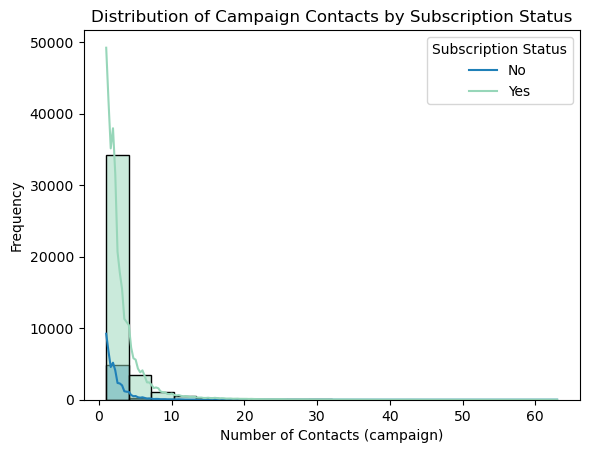

In [17]:
# Plotting the distribution of 'campaign' by subscription status
sns.histplot(data=bank_df, x='campaign', hue='y', bins=20, kde=True, palette='YlGnBu', edgecolor='black')
plt.title('Distribution of Campaign Contacts by Subscription Status')
plt.xlabel('Number of Contacts (campaign)')
plt.ylabel('Frequency')
plt.legend(title='Subscription Status', labels=['No', 'Yes'])

plt.show()

In [18]:
# Campaign values with counts >= 100
valid_campaigns = campaign_counts[campaign_counts >= 100].index

# Filter the DataFrame to include only rows where the campaign is in the valid_campaigns
# and where the jobtype is  'unknown' 
filtered_bank_df = bank_df[(bank_df['campaign'].isin(valid_campaigns)) & (bank_df['job'] != 'unknown') & (bank_df['duration'] <= 2000)]

In [19]:
filtered_bank_df.shape

(44166, 17)

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\788720999.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subscription_rate = data.groupby(['balance_bin', 'duration_bin'])['subscription'].mean().unstack()


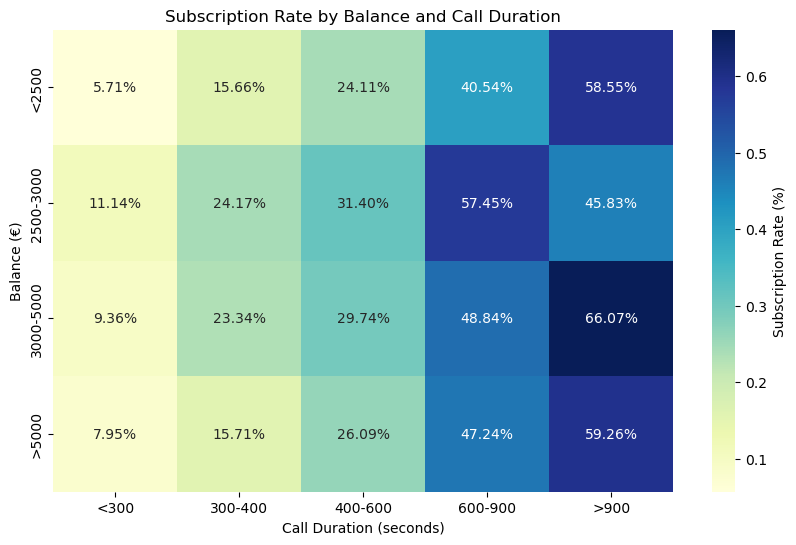

In [20]:
data = filtered_bank_df.copy()
data['subscription'] = data['y']

# Bins for balance and duration
balance_bins = [0, 2500, 3000, 5000, 10000] 
duration_bins = [0, 300, 400, 600, 900, 1200] 

balance_labels = ['<2500', '2500-3000', '3000-5000', '>5000']
duration_labels = ['<300', '300-400', '400-600', '600-900', '>900']
data['balance_bin'] = pd.cut(data['balance'], bins=balance_bins, labels=balance_labels)
data['duration_bin'] = pd.cut(data['duration'], bins=duration_bins, labels=duration_labels)

# Subscription rate
subscription_rate = data.groupby(['balance_bin', 'duration_bin'])['subscription'].mean().unstack()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(subscription_rate, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Subscription Rate (%)'})
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Balance (€)")
plt.title("Subscription Rate by Balance and Call Duration")
plt.show() 

In [21]:
# Dummies for categorical variables
bank_dummies_df = pd.get_dummies(filtered_bank_df, drop_first = True, dtype = int)

In [22]:
# Correlation matrix of the variables

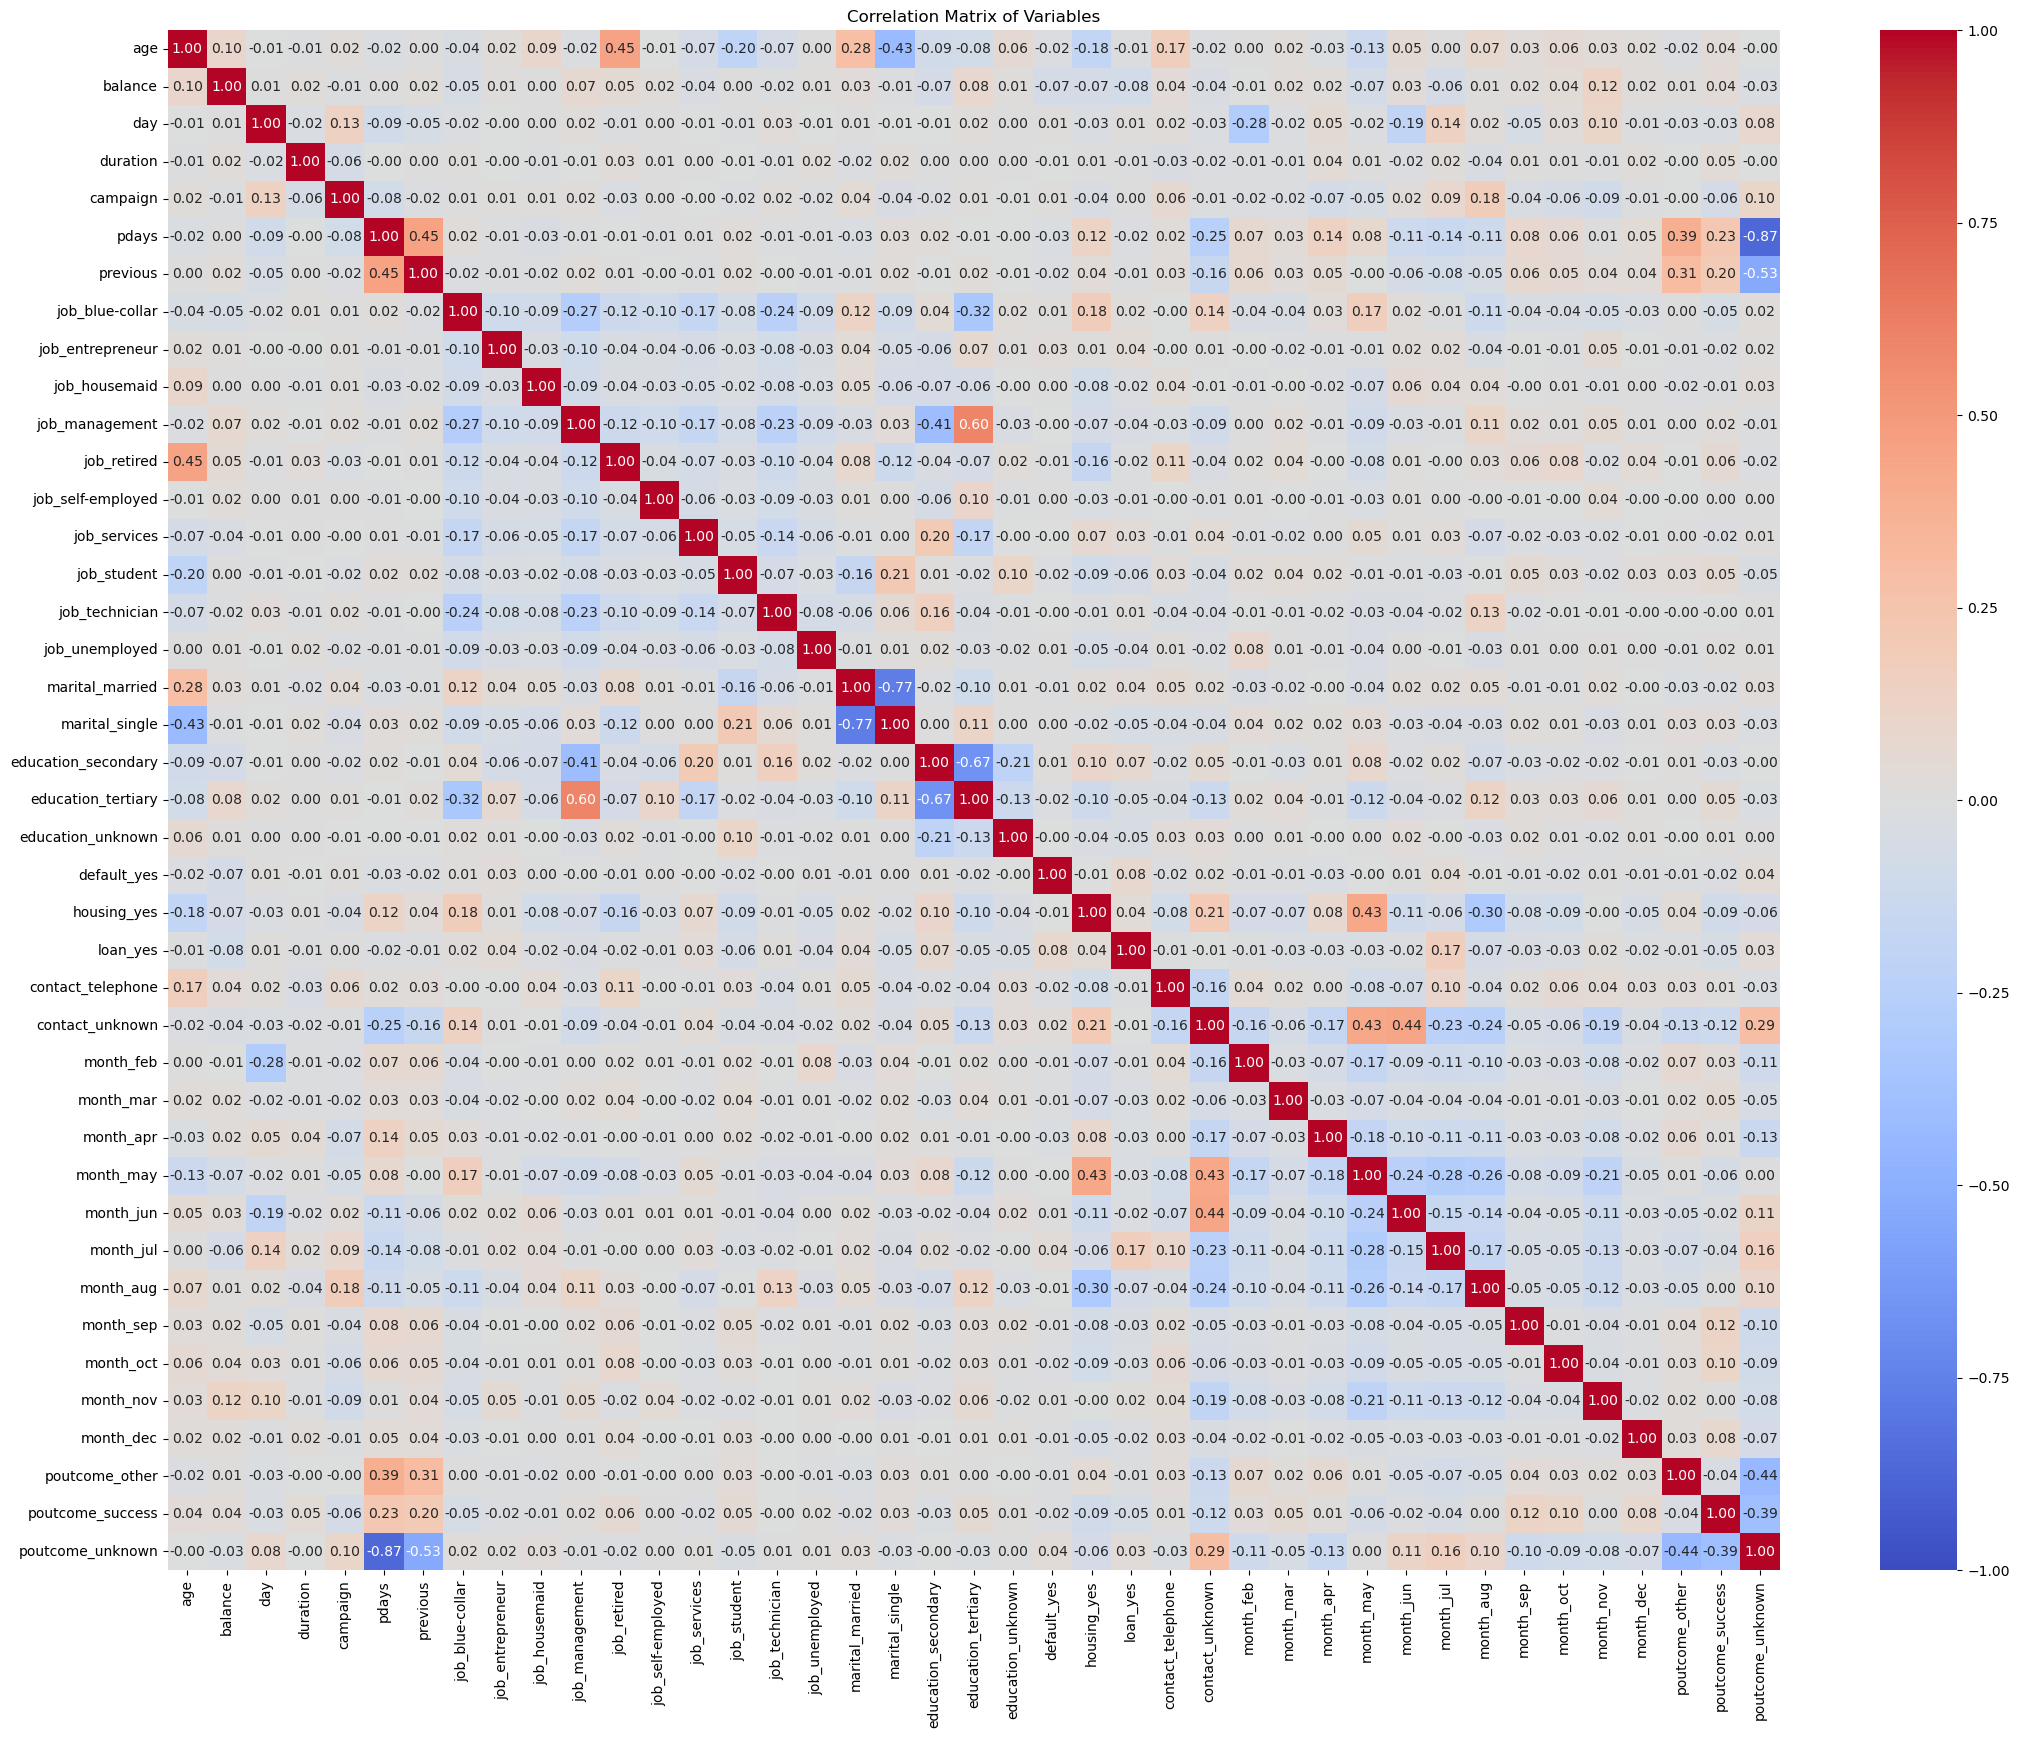

Highly Correlated Feature Pairs (Correlation > 0.8):
pdays - poutcome_unknown: Correlation = -0.87
pdays - poutcome_unknown: Correlation = -0.87


In [23]:
corr_matrix = bank_dummies_df.drop(['y'], axis=1).corr()

plt.figure(figsize=(26, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Variables")
plt.show()

# Highly correlated feature pairs
threshold = 0.8
high_corr_pairs = []
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold:
            pair = tuple(sorted([col1, col2]))  # Sort to avoid duplicate pairs
            if pair not in high_corr_pairs:
                high_corr_pairs.append(pair + (corr_matrix.loc[col1, col2],))

print("Highly Correlated Feature Pairs (Correlation > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: Correlation = {pair[2]:.2f}")

In [24]:
# Checking for multi-colinearity via Variance Inflation Factor

In [25]:
X = bank_dummies_df.drop(columns='y') 

# VIF for each feature
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

               Features        VIF
0                   age  20.395386
1               balance   1.263659
2                   day   5.522687
3              duration   2.133733
4              campaign   2.801439
5                 pdays   4.478960
6              previous   1.478715
7       job_blue-collar   3.005758
8      job_entrepreneur   1.336106
9         job_housemaid   1.303072
10       job_management   3.746333
11          job_retired   1.803572
12    job_self-employed   1.352623
13         job_services   1.760452
14          job_student   1.248416
15       job_technician   2.453728
16       job_unemployed   1.260735
17      marital_married   5.886571
18       marital_single   3.499933
19  education_secondary   4.870305
20   education_tertiary   4.490589
21    education_unknown   1.295655
22          default_yes   1.033381
23          housing_yes   3.217988
24             loan_yes   1.259301
25    contact_telephone   1.166649
26      contact_unknown   3.337184
27            month_

In [26]:
# Feature importance

In [27]:
# Segregating independent and target variables
x = bank_dummies_df.drop(columns='y')  
y = bank_dummies_df['y'] 

# Fit the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=19)
clf.fit(x, y)

feature_importances = pd.DataFrame({
    'feature': x.columns,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

                feature  importance
3              duration    0.270592
1               balance    0.113203
39     poutcome_success    0.092056
0                   age    0.089622
2                   day    0.087530
5                 pdays    0.046158
4              campaign    0.030960
23          housing_yes    0.024575
29            month_apr    0.016669
28            month_mar    0.015992
6              previous    0.014330
26      contact_unknown    0.011653
31            month_jun    0.011547
35            month_oct    0.011509
20   education_tertiary    0.010541
15       job_technician    0.009730
27            month_feb    0.009543
17      marital_married    0.009467
30            month_may    0.009101
19  education_secondary    0.009073
33            month_aug    0.008911
36            month_nov    0.008440
10       job_management    0.007956
18       marital_single    0.007452
34            month_sep    0.007023
32            month_jul    0.006497
13         job_services    0

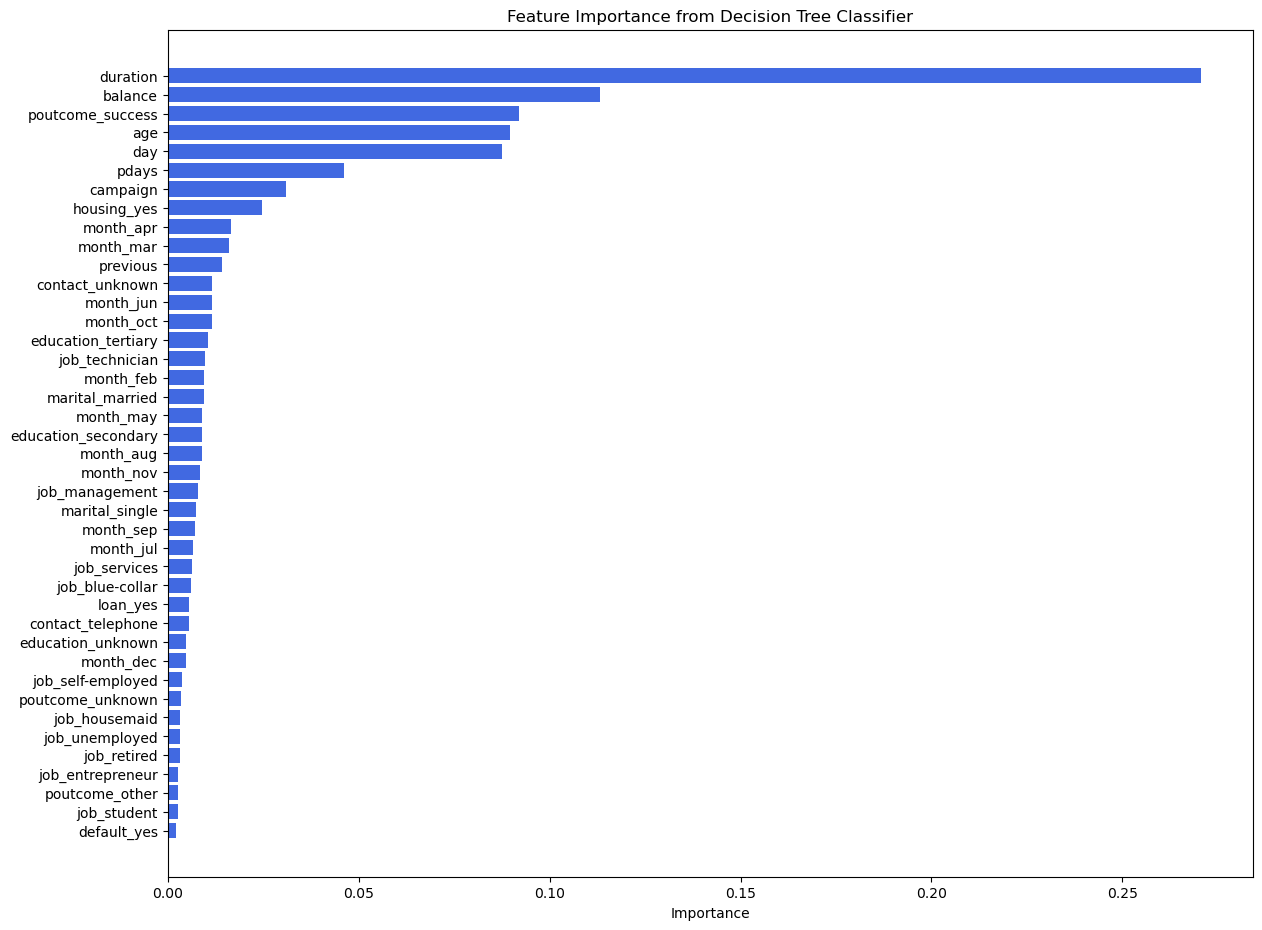

In [28]:
# Visualizing the feature importances
plt.figure(figsize=(14, 11))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='royalblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.gca().invert_yaxis() 
plt.show()

In [29]:
# Selecting relevant columns for modeling

In [30]:
# Removing poutcome_unknown as its VIF is high and is also highly co-related to pdays. Also, pdays has more feature importance compared to poutcome_unknown
# Removing education, marital, loan_yes, default_yes and their encoded variables as their feature importance is less than 0.01
bank_final_df = bank_dummies_df[
                                 [
                                      'age', 'balance', 'duration', 'campaign', 'pdays', 'day','previous',
                                      'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                                      'job_management', 'job_retired', 'job_self-employed', 'job_services',
                                      'job_student', 'job_technician', 'job_unemployed', 'housing_yes', 
                                      'contact_telephone', 'contact_unknown', 'month_feb',
                                      'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul',
                                      'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec',
                                      'poutcome_other', 'poutcome_success', 'y'
                                 ]
                               ]

In [31]:
bank_final_df['y'].value_counts().sort_index()

y
0    38962
1     5204
Name: count, dtype: int64

In [32]:
# Balancing the data by duplicating records as number of 1's(11.84%) are very less compared to 0's(88.16%)

In [33]:
# Separate the data into majority and minority classes
data_majority = bank_final_df[bank_final_df['y'] == 0]  # Adjust if 0 is the majority class
data_minority = bank_final_df[bank_final_df['y'] == 1]  # Adjust if 1 is the minority class

# Calculating duplication factor
duplication_factor = len(data_majority) // len(data_minority)

# Duplicate the minority class
data_minority_duplicated = pd.concat([data_minority] * duplication_factor, ignore_index=True)

# Combining the majority class and duplicated minority class
balanced_df = pd.concat([data_majority, data_minority_duplicated], ignore_index=True)

balanced_data_majority = balanced_df[balanced_df['y'] == 0]
balanced_data_minority = balanced_df[balanced_df['y'] == 1]

print("Number of majority class instances after balancing:", len(balanced_data_majority))
print("Number of minority class instances after balancing:", len(balanced_data_minority))
print("Balanced dataset shape:", balanced_df.shape)

Number of majority class instances after balancing: 38962
Number of minority class instances after balancing: 36428
Balanced dataset shape: (75390, 34)


In [34]:
# Target and predictors variable(s)
X = balanced_df[
                    [
                          'age', 'balance', 'duration', 'campaign', 'pdays', 'day','previous',
                          'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                          'job_management', 'job_retired', 'job_self-employed', 'job_services',
                          'job_student', 'job_technician', 'job_unemployed', 
                          'housing_yes', 'contact_telephone', 'contact_unknown', 'month_feb',
                          'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul',
                          'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec',
                          'poutcome_other', 'poutcome_success'
                    ]
               ]

y = balanced_df['y']

In [35]:
# Logistic Regression model

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\3436868330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration'] = np.log1p(X['duration'])  # log1p handles zero values by computing log(1 + x)


Accuracy: 0.82802758986603

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      7792
           1       0.81      0.84      0.83      7286

    accuracy                           0.83     15078
   macro avg       0.83      0.83      0.83     15078
weighted avg       0.83      0.83      0.83     15078


ROC- Area under curve:
 0.9058477278581579


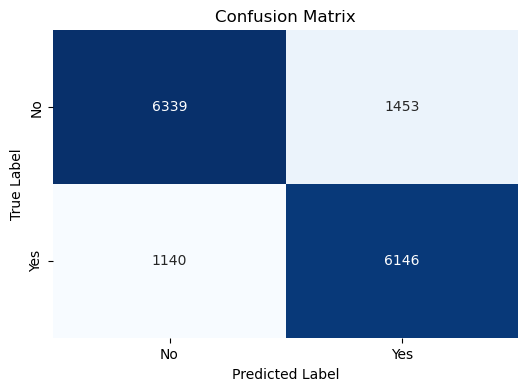

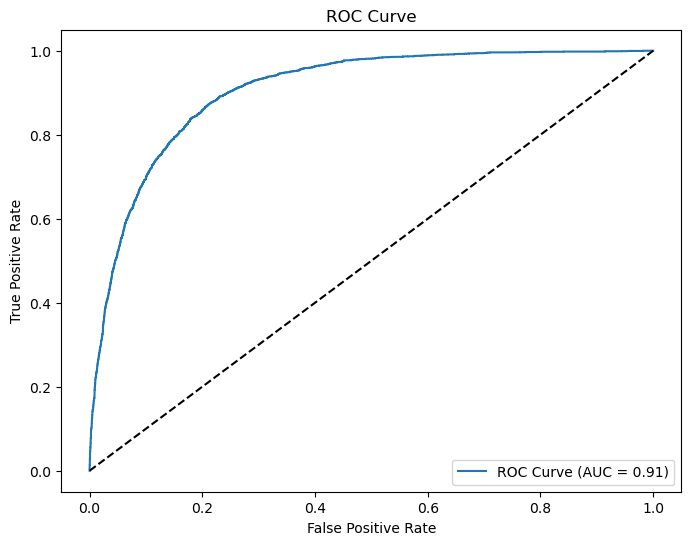


Logit Equation: log(odds) = -0.4472 + -0.0840*age + 0.0858*balance + 1.9445*duration + -0.1991*campaign + 0.0280*pdays + 0.0733*day + 0.0811*previous + -0.5113*job_blue-collar + -0.4529*job_entrepreneur + -0.5855*job_housemaid + -0.0465*job_management + 0.2406*job_retired + -0.3287*job_self-employed + -0.4075*job_services + 0.6323*job_student + -0.2133*job_technician + -0.2206*job_unemployed + -0.7991*housing_yes + -0.0360*contact_telephone + -1.4989*contact_unknown + 1.3808*month_feb + 3.3980*month_mar + 1.3343*month_apr + 0.6242*month_may + 1.5317*month_jun + 0.1739*month_jul + 0.4834*month_aug + 2.4245*month_sep + 2.7245*month_oct + 0.3413*month_nov + 1.8349*month_dec + 0.2946*poutcome_other + 2.5742*poutcome_success

Feature Summary with Coefficient, Odds, and Probability:
              Feature  Coefficient       Odds  Probability
0                 age    -0.083972   0.919457     0.479019
1             balance     0.085810   1.089600     0.521439
2            duration     1.944497

In [36]:
# Define and scale numerical features for Logistic Regression
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'day', 'previous']
scaler = StandardScaler()

# Duration data is rightly skewed
X['duration'] = np.log1p(X['duration'])  # log1p handles zero values by computing log(1 + x)
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X_scaled[numerical_features])

# Train-Test Split - 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=19, stratify=y)

# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=19, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)
print("\nROC- Area under curve:\n", roc_auc)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Coefficients
coefficients = logreg.coef_[0]
feature_names = X_scaled.columns

# Odds and Probability calculation
odds = np.exp(coefficients)  # Odds ratio
probability = odds / (1 + odds)  # Probability from odds

# DataFrame of features, coefficients, odds, and probability
feature_summary = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds': odds,
    'Probability': probability
})

# Logit Equation
intercept = logreg.intercept_[0]
print(f"\nLogit Equation: log(odds) = {intercept:.4f} + " + " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(coefficients, feature_names)]))

# Feature Summary
print("\nFeature Summary with Coefficient, Odds, and Probability:")
print(feature_summary)

In [37]:
# Summary of logistic Regression

In [38]:
# Add an intercept column to X_train for statsmodels (sklearn adds it automatically, but statsmodels does not)
X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictors

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

print(result.summary())

# Extracting coefficients, p-values, and other statistics into a DataFrame
summary_df = pd.DataFrame({
    "Feature": X_train_sm.columns,
    "Coefficient": result.params.values,
    "P-value": result.pvalues.values
})

print(summary_df)

Optimization terminated successfully.
         Current function value: 0.391196
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60312
Model:                          Logit   Df Residuals:                    60278
Method:                           MLE   Df Model:                           33
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.4352
Time:                        23:07:56   Log-Likelihood:                -23594.
converged:                       True   LL-Null:                       -41771.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5925      0.074     -7.997      0.000      -0.738      -0.447
age     

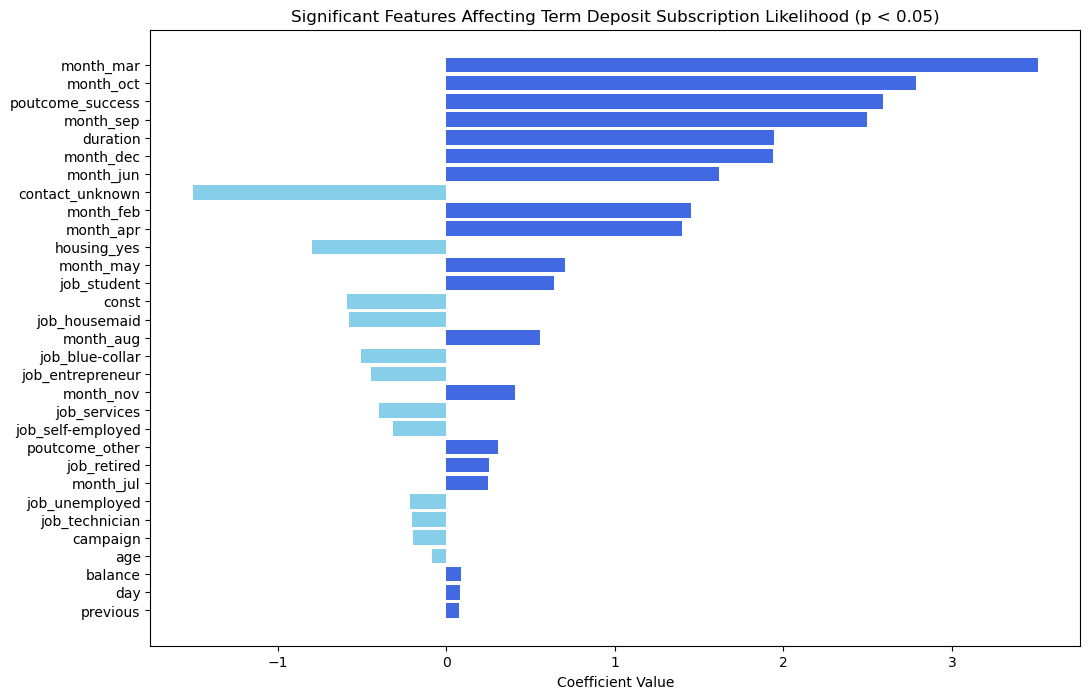

In [39]:
# Filter significant features based on their p-value
significant_features = summary_df[summary_df['P-value'] < 0.05].sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(significant_features['Feature'], significant_features['Coefficient'], color=np.where(significant_features['Coefficient'] > 0, 'royalblue', 'skyblue'))
plt.xlabel("Coefficient Value")
plt.title("Significant Features Affecting Term Deposit Subscription Likelihood (p < 0.05)")
plt.gca().invert_yaxis()  
plt.show()

In [40]:
# Decision Tree Classifier

Accuracy: 0.8629791749568908

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      7792
           1       0.83      0.91      0.86      7286

    accuracy                           0.86     15078
   macro avg       0.87      0.86      0.86     15078
weighted avg       0.87      0.86      0.86     15078


ROC- Area under curve:
 0.9261090913151773


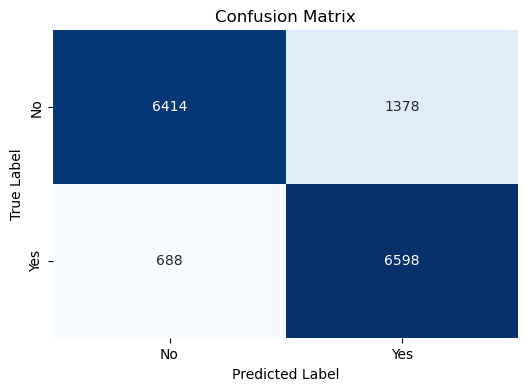

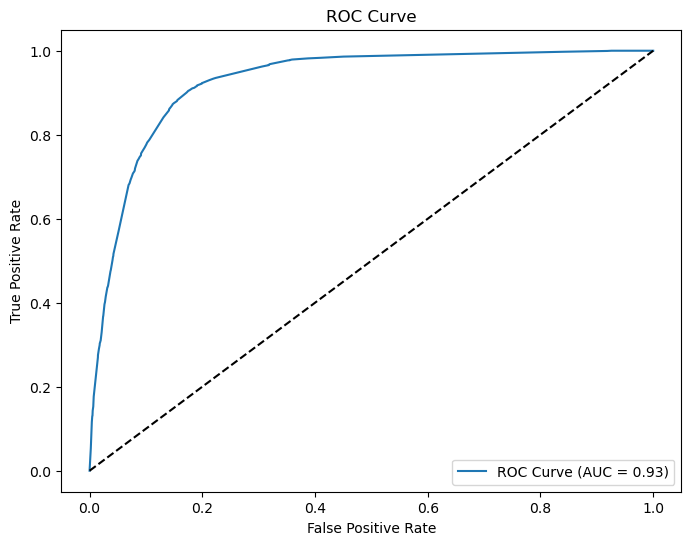

In [41]:
# Define the depth of the tree for model tuning and performance
max_depth = 10  

# Initialize and train the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=19, max_depth=max_depth, class_weight='balanced')
dt_clf.fit(X_train, y_train)

# Predictions
y_pred = dt_clf.predict(X_test)
y_pred_proba = dt_clf.predict_proba(X_test)[:, 1]  

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", class_report)
print("\nROC- Area under curve:\n", roc_auc)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Save predictions to CSV because the accuracy of Decision Tree is more 
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Predicted_Probability': y_pred_proba
})

predictions_df.to_csv('term_deposit_predictions.csv', index=False)

In [42]:
importances = dt_clf.feature_importances_

# DataFrame of features and their scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

             Feature  Importance
2           duration    0.455487
32  poutcome_success    0.118243
19   contact_unknown    0.109324
17       housing_yes    0.059069
5                day    0.040291
21         month_mar    0.031880
1            balance    0.024894
4              pdays    0.022016
25         month_jul    0.019105
0                age    0.018030


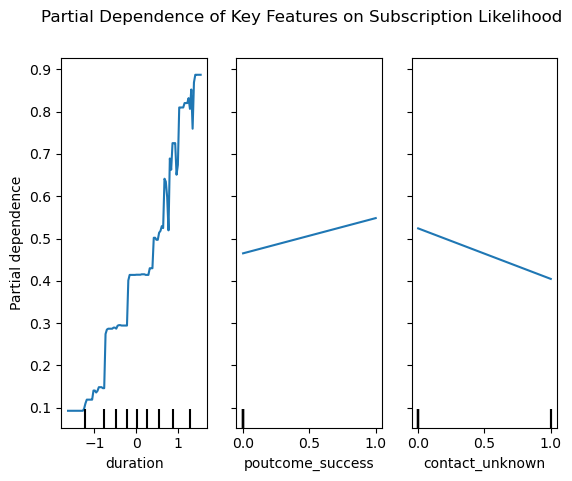

In [43]:
# Plot Partial Dependence for the top features
PartialDependenceDisplay.from_estimator(dt_clf, X_train, features=[2, 32, 19])  
plt.suptitle("Partial Dependence of Key Features on Subscription Likelihood")
plt.show()

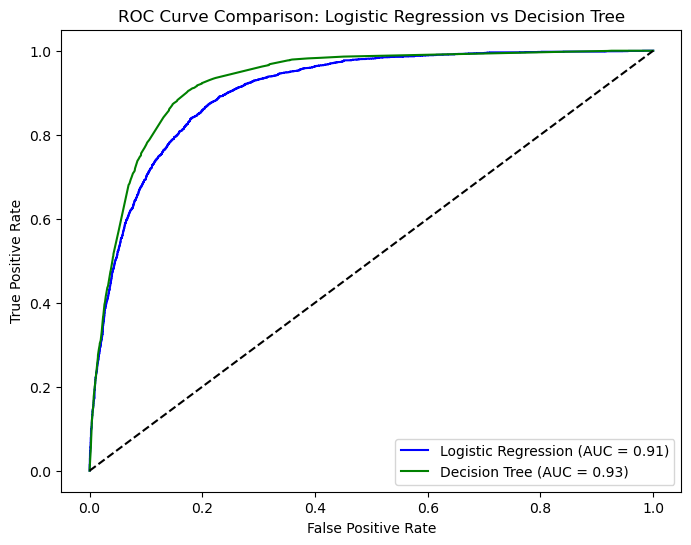

In [44]:
# ROC for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

# ROC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_clf.predict_proba(X_test)[:, 1])
roc_auc_dt = roc_auc_score(y_test, dt_clf.predict_proba(X_test)[:, 1])

# Plotting both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})", color="blue")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", color="green")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic Regression vs Decision Tree")
plt.legend(loc="lower right")
plt.show()

#### Ques 2: Seasonal trends in call duration, monthly patterns, and subscription counts for predicting the likelihood of a customer subscribing to a term deposit

In [45]:
bank_q2_df = bank_df.copy()

In [46]:
monthly_data = bank_q2_df.groupby('month').agg(
                                                avg_duration=('duration', 'mean'),
                                                subscriber_count=('y', 'sum')
                                              ).reset_index()
monthly_data

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\1661960173.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_data = bank_q2_df.groupby('month').agg(


,month,avg_duration,subscriber_count
0,jan,268.220242,142
1,feb,248.298226,441
2,mar,244.400419,248
3,apr,298.098909,577
4,may,260.922272,925
5,jun,243.087811,546
6,jul,267.975344,627
7,aug,232.402113,688
8,sep,292.252159,269
9,oct,288.302168,323


In [47]:
# Data Analysis & Visualization

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\3000204479.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_data = bank_q2_df.groupby('month').agg(


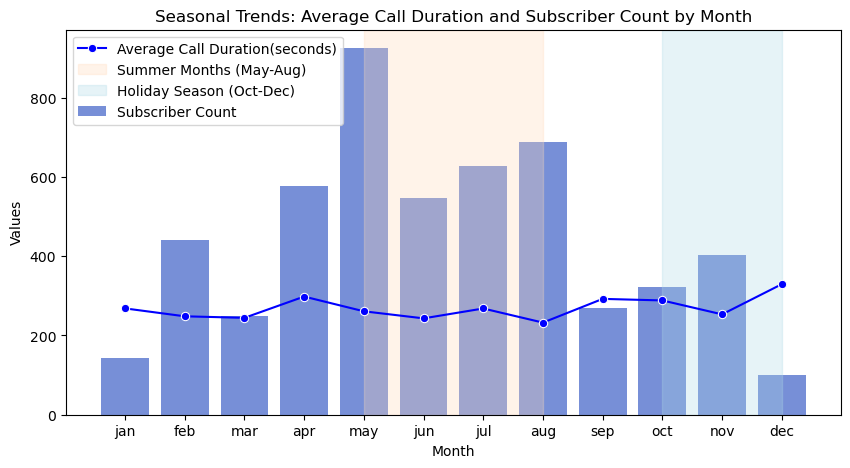

In [48]:
# Ordering month as a categorical variable
bank_q2_df['month'] = pd.Categorical(
                                        bank_q2_df['month'],
                                        categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                        ordered=True
                                    )

# Calculating monthly average duration and subscriber counts
monthly_data = bank_q2_df.groupby('month').agg(
                                                avg_duration=('duration', 'mean'),
                                                subscriber_count=('y', 'sum')
                                              ).reset_index()

# Plot
plt.figure(figsize=(10, 5))

# Monthly average duration (line plot for trend)
sns.lineplot(data=monthly_data, x='month', y='avg_duration', marker='o', color='blue', label="Average Call Duration(seconds)")

# Monthly subscriber count (bar plot)
sns.barplot(data=monthly_data, x='month', y='subscriber_count', color='royalblue', alpha=0.8, label="Subscriber Count")

# Background shading for seasonal periods
plt.axvspan(4, 7, color='peachpuff', alpha=0.3, label="Summer Months (May-Aug)")
plt.axvspan(9, 11, color='lightblue', alpha=0.3, label="Holiday Season (Oct-Dec)")
plt.xlabel("Month")
plt.ylabel("Values")
plt.title("Seasonal Trends: Average Call Duration and Subscriber Count by Month")
plt.legend(loc='upper left')
plt.show()

In [49]:
# Creating dummies for categorical variables
bank_q2_dummies_df = pd.get_dummies(bank_q2_df, columns=['month'], drop_first=True)

In [50]:
# Correlation analysis of features

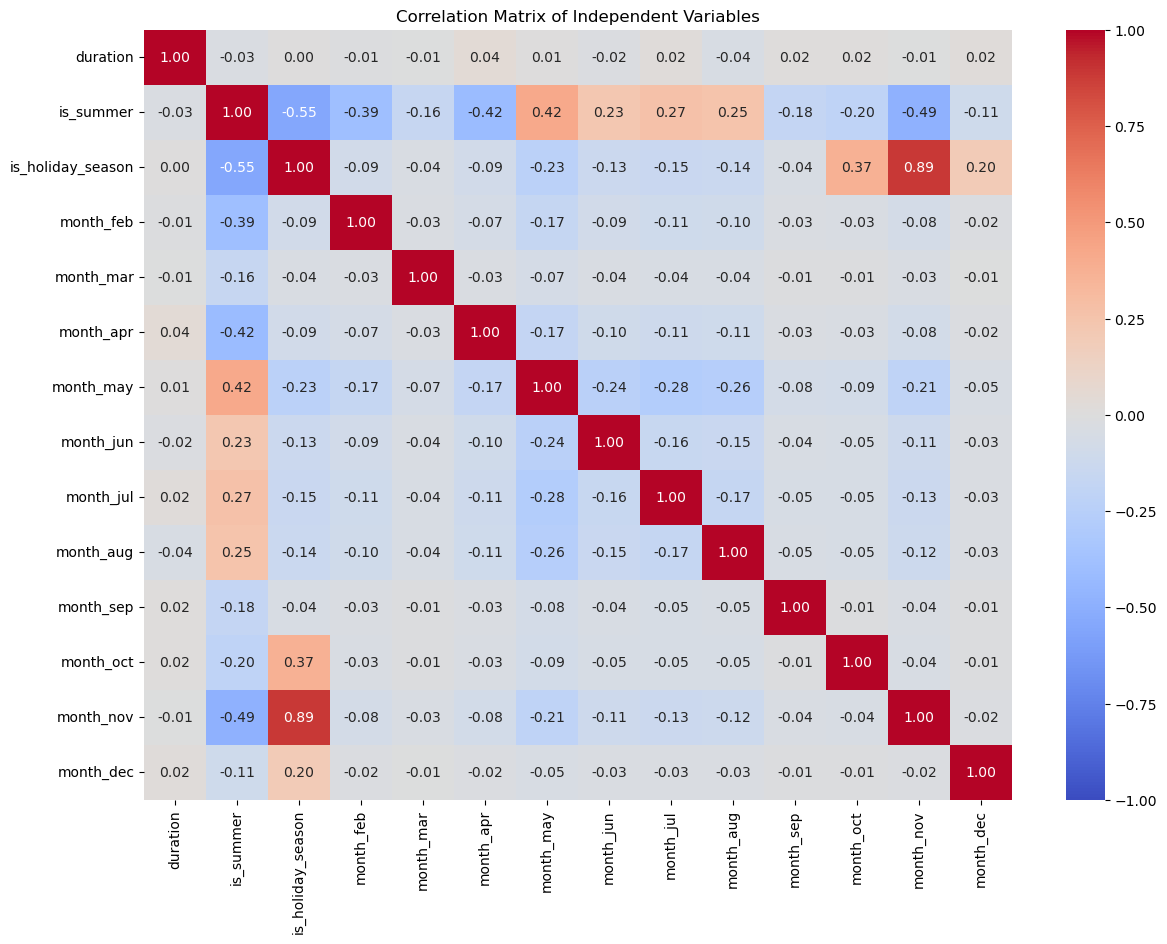

Highly Correlated Feature Pairs (Correlation > 0.8):
is_holiday_season - month_nov: Correlation = 0.89
month_nov - is_holiday_season: Correlation = 0.89


In [51]:
# Seasonal indicators for summer and holiday seasons
bank_q2_dummies_df['is_summer'] = bank_q2_dummies_df[['month_may', 'month_jun', 'month_jul', 'month_aug']].sum(axis=1).astype(bool).astype(int)
bank_q2_dummies_df['is_holiday_season'] = bank_q2_dummies_df[['month_oct', 'month_nov', 'month_dec']].sum(axis=1).astype(bool).astype(int)

# Define features and target
features = ['duration', 'is_summer', 'is_holiday_season'] + [col for col in bank_q2_dummies_df.columns if col.startswith('month_')]
X = bank_q2_dummies_df[features]
y = bank_q2_dummies_df['y'] 

corr_matrix = X.corr()

# Correlation matrix plot
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Independent Variables")
plt.show()

# Identifying highly correlated pairs
threshold = 0.8
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2]) 
                   for col1 in corr_matrix.columns 
                   for col2 in corr_matrix.columns 
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]

print("Highly Correlated Feature Pairs (Correlation > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: Correlation = {pair[2]:.2f}")

In [52]:
bank_q2_final_df = bank_q2_dummies_df[
                                        [
                                           'duration', 'is_summer', 'is_holiday_season', 'month_feb', 'month_mar',
                                           'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug',
                                           'month_sep', 'month_oct', 'month_nov', 'month_dec', 'y'
                                        ]
                                    ]

In [53]:
bank_q2_final_df['y'].value_counts().sort_index()

y
0    39922
1     5289
Name: count, dtype: int64

In [54]:
# Balancing the data

In [55]:
# Separate the data into majority and minority classes
data_majority = bank_q2_final_df[bank_q2_final_df['y'] == 0]  # Adjust if 0 is the majority class
data_minority = bank_q2_final_df[bank_q2_final_df['y'] == 1]  # Adjust if 1 is the minority class

# Calculating duplication factor
duplication_factor = len(data_majority) // len(data_minority)

# Duplicate the minority class
data_minority_duplicated = pd.concat([data_minority] * duplication_factor, ignore_index=True)

# Combining the majority class and duplicated minority class
balanced_q2_df = pd.concat([data_majority, data_minority_duplicated], ignore_index=True)

balanced_data_majority = balanced_q2_df[balanced_q2_df['y'] == 0]
balanced_data_minority = balanced_q2_df[balanced_q2_df['y'] == 1]

print("Number of majority class instances after balancing:", len(balanced_data_majority))
print("Number of minority class instances after balancing:", len(balanced_data_minority))
print("Balanced dataset shape:", balanced_q2_df.shape)

Number of majority class instances after balancing: 39922
Number of minority class instances after balancing: 37023
Balanced dataset shape: (76945, 15)


In [56]:
# Defining the independent and dependent variables for modeling
X = balanced_q2_df[features]
y = balanced_q2_df['y']

C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\415319506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['duration'] = np.log1p(X['duration'])  # log1p applies log(1 + x) to handle zero values
C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\415319506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['duration']] = scaler.fit_transform(X[['duration']])  # Scaling only 'log_duration'


Accuracy: 0.7806225225810643
ROC-AUC Score: 0.8641146658610942

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      7984
           1       0.77      0.78      0.77      7405

    accuracy                           0.78     15389
   macro avg       0.78      0.78      0.78     15389
weighted avg       0.78      0.78      0.78     15389



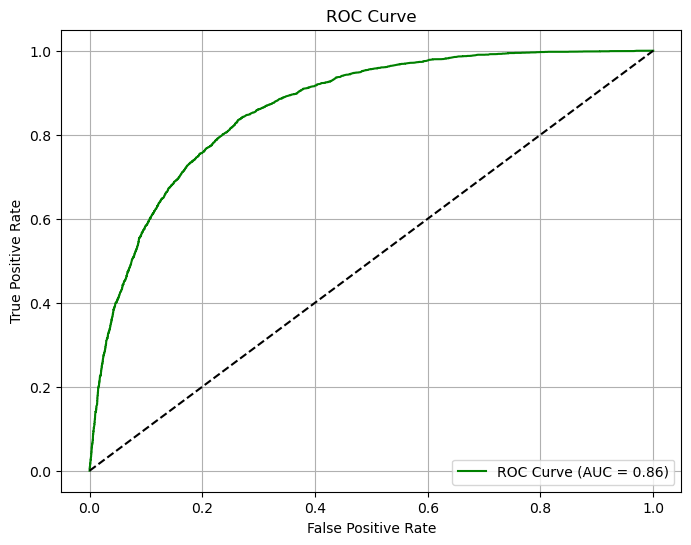


Sorted Coefficients (by absolute value):
              Feature  Coefficient       Odds  Probability
4           month_mar     2.999619  20.077885     0.952557
10          month_sep     2.389751  10.910781     0.916042
0            duration     1.757074   5.795456     0.852843
11          month_oct     1.276224   3.583083     0.781806
2   is_holiday_season     1.152672   3.166642     0.759999
12          month_nov    -1.070976   0.342674     0.255217
3           month_feb     1.005863   2.734266     0.732210
13          month_dec     0.947424   2.579058     0.720597
5           month_apr     0.867897   2.381896     0.704308
6           month_may    -0.613184   0.541623     0.351333
9           month_aug     0.385280   1.470026     0.595146
7           month_jun     0.284472   1.329060     0.570642
8           month_jul    -0.241477   0.785467     0.439922
1           is_summer    -0.184910   0.831179     0.453904

Logit Equation:
log(odds) = -0.2844 + 1.7571*duration + -0.1849*is_summe

In [57]:
# Log transform the 'duration' feature
X['duration'] = np.log1p(X['duration'])  # log1p applies log(1 + x) to handle zero values

# Scaling numerical features
scaler = StandardScaler()
X[['duration']] = scaler.fit_transform(X[['duration']])  # Scaling only 'log_duration'

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=19, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Accuracy:", accuracy)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="green", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Coefficients from the logistic regression model
intercept = logreg.intercept_[0]  
coefficients = logreg.coef_[0]    
feature_names = X.columns 

# DataFrame to display the coefficients, odds, and probabilities
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds': np.exp(coefficients),  # Odds = exp(Coefficient)
    'Probability': np.exp(coefficients) / (1 + np.exp(coefficients))  # Probability from odds
})

# Coefficients
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
print("\nSorted Coefficients (by absolute value):")
print(coef_df)

# logit equation
logit_equation = f"log(odds) = {intercept:.4f} + " + " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(coefficients, feature_names)])
print("\nLogit Equation:")
print(logit_equation)

# DataFrame to save actual values, predicted values, and predicted probabilities
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Predicted_Probability': y_pred_proba
})

# Save to CSV file
predictions_df.to_csv('term_deposit_predictions_by_seasonality.csv', index=False)

In [58]:
# Segmenting customers based on likelihood of subscribing

In [59]:
X['predicted_probability'] = logreg.predict_proba(X)[:, 1] 

# Segments based on probability thresholds
X['subscription_likelihood'] = pd.cut(X['predicted_probability'], bins=[0, 0.5, 0.75, 1], 
                                      labels=['Less Likely', 'Moderately Likely', 'Highly Likely'])

print(X['subscription_likelihood'].value_counts())

subscription_likelihood
Less Likely          39153
Highly Likely        22320
Moderately Likely    15472
Name: count, dtype: int64


C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\2689020363.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_likelihood_counts = X.groupby(['season', 'subscription_likelihood']).size().reset_index(name='customer_count')


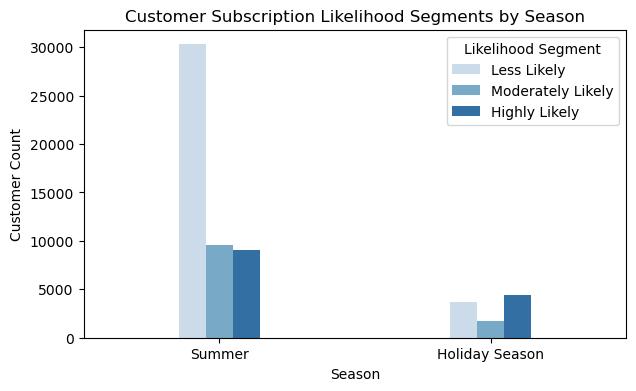

In [60]:
# Season column based on the 'is_summer' and 'is_holiday_season' 
X['season'] = np.select(
    [
        X['is_summer'] == 1,
        X['is_holiday_season'] == 1
    ],
    [
        'Summer',
        'Holiday Season'
    ]
)

# Aggregate data to count the number of customers in each likelihood segment per season
seasonal_likelihood_counts = X.groupby(['season', 'subscription_likelihood']).size().reset_index(name='customer_count')

seasonal_order = ['Summer', 'Holiday Season']
seasonal_likelihood_counts['season'] = pd.Categorical(seasonal_likelihood_counts['season'], categories=seasonal_order, ordered=True)

# Plot the data
plt.figure(figsize=(7, 4))
sns.barplot(data=seasonal_likelihood_counts, x='season', y='customer_count', hue='subscription_likelihood', palette="Blues", width = 0.3)
plt.title("Customer Subscription Likelihood Segments by Season")
plt.xlabel("Season")
plt.ylabel("Customer Count")
plt.legend(title="Likelihood Segment", loc='upper right')
plt.show()


#### Ques 3 Financial and demographic characteristics of clients who are likely to have a housing loan

In [61]:
bank_q3_df = bank_df.copy()

In [62]:
bank_q3_df = bank_q3_df[['balance', 'loan', 'default', 'y', 'marital', 'age', 'housing']]

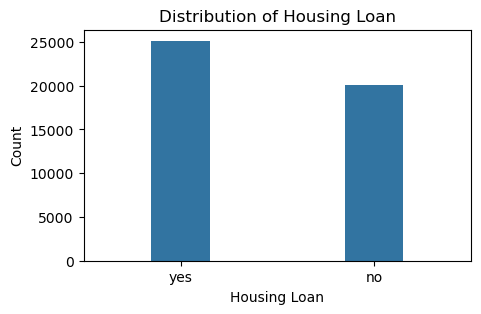

In [63]:
# Distribution of `housing`
plt.figure(figsize=(5, 3))
sns.countplot(data=bank_df, x='housing', width=0.3)
plt.title("Distribution of Housing Loan")
plt.xlabel("Housing Loan")
plt.ylabel("Count")
plt.show()

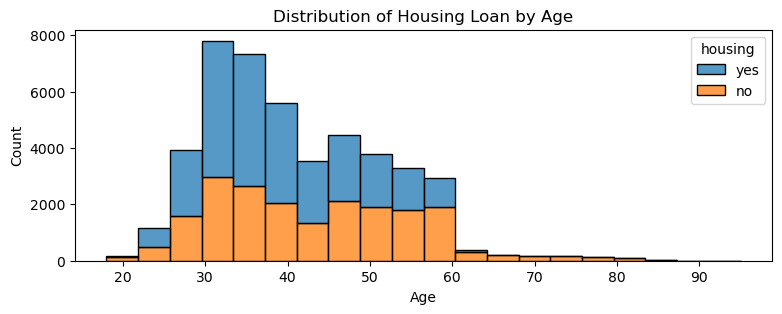

In [64]:
# Housing loan by age
plt.figure(figsize=(9, 3))
sns.histplot(data=bank_q3_df, x='age', hue='housing', multiple='stack', bins=20)
plt.title("Distribution of Housing Loan by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

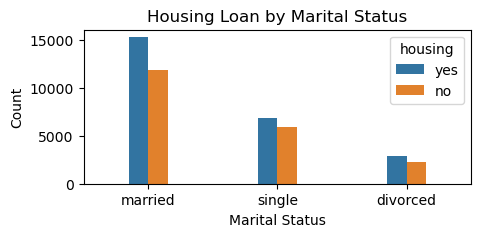

In [65]:
plt.figure(figsize=(5, 2))
sns.countplot(data=bank_q3_df, x='marital', hue='housing',  width =0.3)
plt.title("Housing Loan by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

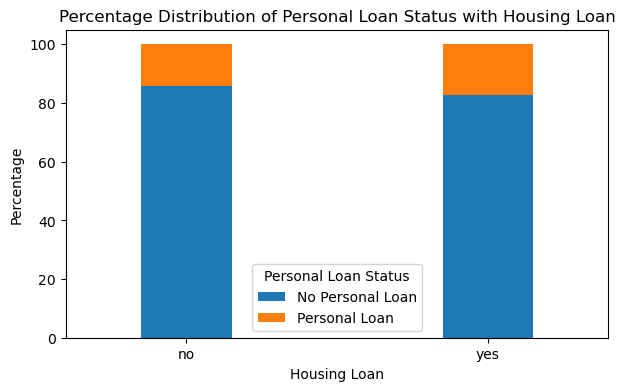

In [66]:
# Distribution of 'housing' loan status by 'loan' status
loan_housing_counts = bank_q3_df.groupby(['housing', 'loan']).size().unstack(fill_value=0)

# Convert counts to percentages
loan_housing_percentages = loan_housing_counts.div(loan_housing_counts.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
loan_housing_percentages.plot(kind='bar', stacked=True, width=0.3, ax=ax)  

plt.title("Percentage Distribution of Personal Loan Status with Housing Loan")
plt.xlabel("Housing Loan")
plt.ylabel("Percentage")
plt.legend(title="Personal Loan Status", labels=['No Personal Loan', 'Personal Loan'])
plt.xticks(rotation=0)
plt.show()

In [67]:
# Converting housing to binary
bank_q3_df['housing'] = bank_q3_df['housing'].map({'yes': 1, 'no': 0}).astype(int)

In [68]:
if 'y' in bank_q3_df.columns:
    bank_q3_df = bank_q3_df.rename(columns={'y': 'term_deposit'})

In [69]:
bank_q3_dummies = pd.get_dummies(bank_q3_df, drop_first=True)

In [70]:
bank_q3_dummies.columns

Index(['balance', 'term_deposit', 'age', 'housing', 'loan_yes', 'default_yes',
       'marital_married', 'marital_single'],
      dtype='object')

In [71]:
# Correlation Matrix of features

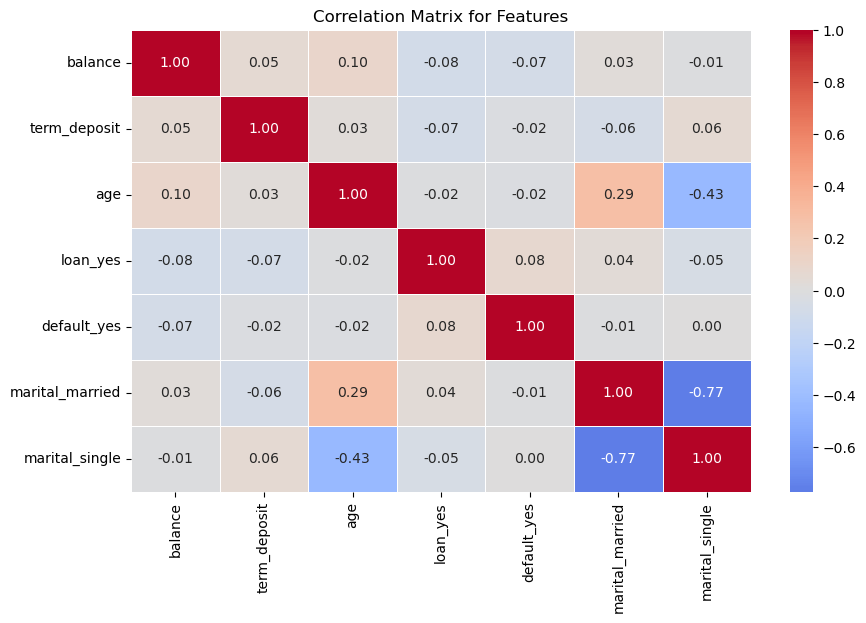

Highly Correlated Feature Pairs (Correlation > 0.8):


In [72]:
correlation_matrix = bank_q3_dummies.drop(columns = 'housing').corr()

# Plot the Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Features")
plt.show()

# Identifying highly correlated pairs
threshold = 0.8
high_corr_pairs = [(col1, col2, correlation_matrix.loc[col1, col2]) 
                   for col1 in correlation_matrix.columns 
                   for col2 in correlation_matrix.columns 
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print("Highly Correlated Feature Pairs (Correlation > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: Correlation = {pair[2]:.2f}")

Feature Importances for Predicting Housing Loan:
           Feature  Importance
0          balance    0.656537
1              age    0.254410
2  marital_married    0.026703
3         loan_yes    0.023721
4     term_deposit    0.017158
5   marital_single    0.013562
6      default_yes    0.007910


C:\Users\Arushi\AppData\Local\Temp\ipykernel_12408\4135725797.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="Blues")


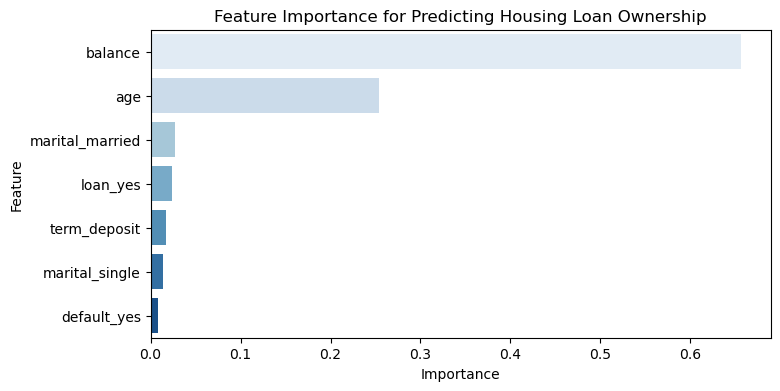

In [73]:
# Define dependent variable and predictors
X = bank_q3_dummies.drop(columns='housing')
y = bank_q3_dummies['housing']

#  Fit the Decision Tree Classifier 
tree_model = DecisionTreeClassifier(random_state=19)
tree_model.fit(X, y)

# Extract and Plot Feature Importance
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importance_df = feature_importances.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
print("Feature Importances for Predicting Housing Loan:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="Blues")
plt.title("Feature Importance for Predicting Housing Loan Ownership")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [74]:
bank_q3_df['housing'].value_counts().sort_index() # More or less balanced data - No need to do balancing

housing
0    20081
1    25130
Name: count, dtype: int64

In [75]:
# Logistic Regression modeling

Accuracy: 0.6103063142762357
ROC-AUC Score: 0.644137614105432

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.56      0.56      4017
           1       0.65      0.65      0.65      5026

    accuracy                           0.61      9043
   macro avg       0.61      0.61      0.61      9043
weighted avg       0.61      0.61      0.61      9043



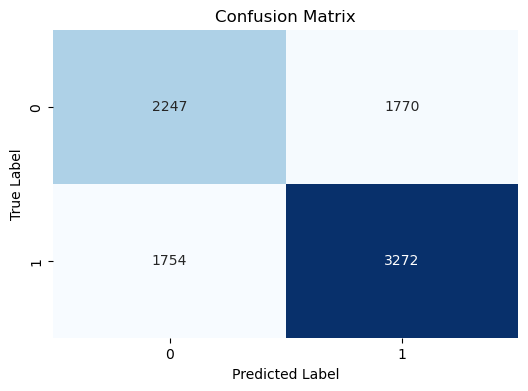


Sorted Coefficients:
           Feature  Coefficient      Odds  Probability
1     term_deposit    -0.842136  0.430789     0.301085
6   marital_single    -0.591587  0.553448     0.356271
2              age    -0.485122  0.615622     0.381043
4      default_yes    -0.278048  0.757261     0.430932
3         loan_yes     0.103118  1.108622     0.525757
0          balance    -0.085798  0.917780     0.478564
5  marital_married    -0.080710  0.922461     0.479833

Logit Equation:
log(odds) = 0.3066 -0.0858*balance + -0.8421*term_deposit + -0.4851*age + 0.1031*loan_yes + -0.2780*default_yes + -0.0807*marital_married + -0.5916*marital_single


In [76]:
# Define the features and target
X = bank_q3_dummies.drop(columns='housing')
y = bank_q3_dummies['housing']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

# Scale the numerical variables
scaler = StandardScaler()
X_train[['balance', 'age']] = scaler.fit_transform(X_train[['balance', 'age']])
X_test[['balance', 'age']] = scaler.transform(X_test[['balance', 'age']])

# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=19, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC calculation

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Accuracy:", accuracy)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Coefficients from the logistic regression model
intercept = logreg.intercept_[0]
coefficients = logreg.coef_[0]
feature_names = X.columns

# DataFrame with feature details, including odds and probability
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds': np.exp(coefficients),  # Odds = exp(Coefficient)
    'Probability': np.exp(coefficients) / (1 + np.exp(coefficients))  # Probability from odds
})

# Coefficients
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
print("\nSorted Coefficients:")
print(coef_df)

# Logit equation
logit_equation = f"log(odds) = {intercept:.4f} " + " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(coefficients, feature_names)])
print("\nLogit Equation:")
print(logit_equation)

Decision Tree Accuracy: 0.6150613734380184
Decision Tree ROC-AUC Score: 0.6269718103155104

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.53      0.55      4017
           1       0.64      0.68      0.66      5026

    accuracy                           0.62      9043
   macro avg       0.61      0.61      0.61      9043
weighted avg       0.61      0.62      0.61      9043



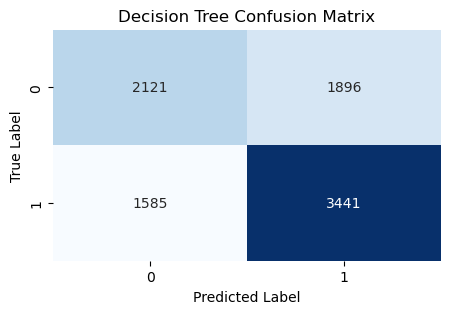

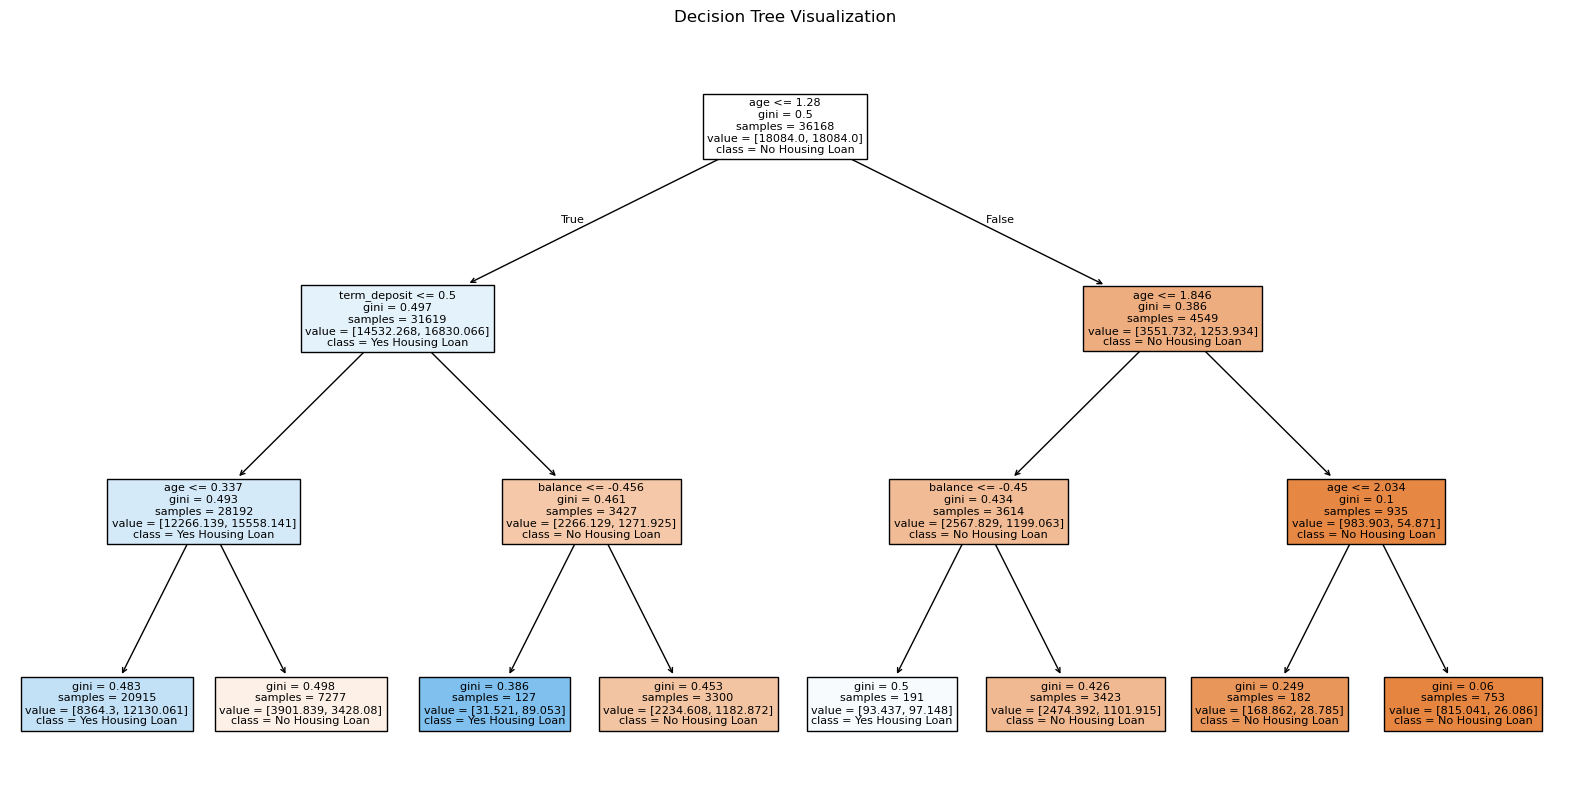

In [77]:
# Predictors and target
X = bank_q3_dummies.drop(columns='housing')
y = bank_q3_dummies['housing']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

# Scaling numerical variables
scaler = StandardScaler()
X_train[['balance', 'age']] = scaler.fit_transform(X_train[['balance', 'age']])
X_test[['balance', 'age']] = scaler.transform(X_test[['balance', 'age']])

# Initialize and train the Decision Tree model
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=19, class_weight='balanced')
dt_clf.fit(X_train, y_train)

# Predictions
y_pred = dt_clf.predict(X_test)
y_pred_proba = dt_clf.predict_proba(X_test)[:, 1] 

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Decision Tree Accuracy:", accuracy)
print("Decision Tree ROC-AUC Score:", roc_auc)
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plt.set_cmap("YlGnBu")
tree.plot_tree(dt_clf, feature_names=X.columns, class_names=['No Housing Loan', 'Yes Housing Loan'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Predicted_Probability': y_pred_proba
})

# Save to a CSV file
predictions_df.to_csv('housing_loan_predictions.csv', index=False)

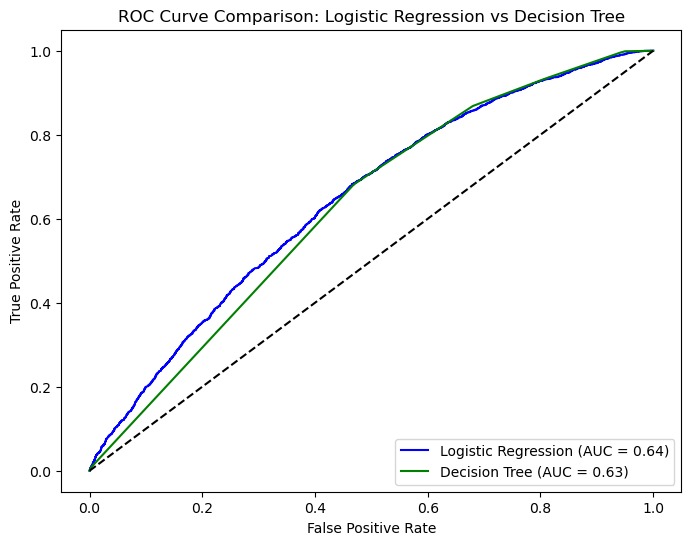

In [78]:
# ROC for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

# ROC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_clf.predict_proba(X_test)[:, 1])
roc_auc_dt = roc_auc_score(y_test, dt_clf.predict_proba(X_test)[:, 1])

# Plotting both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})", color="blue")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", color="green")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic Regression vs Decision Tree")
plt.legend(loc="lower right")
plt.show()